In [1]:
%matplotlib inline
from math import pi, sin, cos
import numpy as np
import openmc
import openmc.deplete
from matplotlib import pyplot

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
fuel = openmc.Material(name='uo2')
fuel.add_element('U',1.0, enrichment=19.75)
fuel.add_element('O',2.0)
fuel.set_density=("g/cc",10.5)
fuel.depletable = True

clad_in = openmc.Material(name='graphite')
clad_in.add_element('C',1.0)
clad_in.set_density=("g/cc",1.5)
clad_in.add_s_alpha_beta('c_Graphite')
clad_in.depletable = False

clad_out = openmc.Material(name='SiC')
clad_out.add_element('C',1.0)
clad_out.add_element('Si',1.0)
clad_out.set_density=("g/cc",2.58)
clad_out.add_s_alpha_beta('c_Graphite')
clad_out.depletable = False

coolant = openmc.Material(name='LiOH+NaOH')
coolant.add_element('Li',.3, enrichment=99.995, enrichment_target='Li7',enrichment_type='ao')
coolant.add_element('H',1.0)
coolant.add_element('O',1.0)
coolant.add_element('Na',.7)
coolant.set_density('g/cc', 1.670)
coolant.depletable = False

moderator = openmc.Material(name='graphite')
moderator.add_element('C',1.0)
moderator.set_density=("g/cc",1.5)
moderator.add_s_alpha_beta('c_Graphite')
moderator.depletable = False

materials = openmc.Materials([fuel,clad_in,clad_out,coolant,moderator])
materials.export_to_xml()

/home/sblair/miniconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/material.py:740: UserWarning: A uranium enrichment of 19.75 was given for Material ID="1". OpenMC assumes the U234/U235 mass ratio is constant at 0.008, which is only valid at low enrichments. Consider setting the isotopic composition manually for enrichments over 5%.
  warnings.warn(msg)


In [3]:
r_fuel   = 0.35
r_clad_1 = 0.5
r_clad_2 = 0.6

r_pt_in  = 7.5 #inner radius of the graphite pressure tube
r_pt_out = 8.5 #outer radius of the graphite pressure tube

lattice_pitch = 18

H=163.345 #core height in cm
D=H #core diameter in cm

ring_radii = np.array([0.0, 2.1, 4.2, 6.2])

surf_fuel = openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r_fuel)

surf_clad_1 = openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r_clad_1)
surf_clad_2 = openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r_clad_2)

surf_pt_1 = openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r_pt_in)
surf_pt_2 = openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r_pt_out)

In [4]:
radial_surf = [openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r) for r in
               (ring_radii[:-1] + ring_radii[1:])/2]

coolant_cells = []
for i in range(ring_radii.size):
    if i == 0:
        coolant_region = -radial_surf[i]
    elif i == ring_radii.size - 1:
        coolant_region = +radial_surf[i-1] & -surf_pt_1
    else:
        coolant_region = +radial_surf[i-1] & -radial_surf[i]

    coolant_cells.append(openmc.Cell(fill=coolant, region=coolant_region))

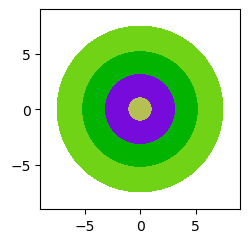

In [5]:
plot_args = {'width':(lattice_pitch,lattice_pitch)}
bundle_universe = openmc.Universe(cells=coolant_cells)
bundle_universe.plot(**plot_args)

In [6]:
coolant.temperature = 973

fuel_cell = openmc.Cell(fill=fuel, region=-surf_fuel)
fuel_cell.temperature = 1473

clad_cell_1 = openmc.Cell(fill=clad_in, region=+surf_fuel & -surf_clad_1)
clad_cell_1.temperature = 1273

clad_cell_2 = openmc.Cell(fill=clad_out, region=+surf_clad_1 & -surf_clad_2)
clad_cell_2.temperature = 973

pin_universe = openmc.Universe(cells=(fuel_cell,clad_cell_1,clad_cell_2))

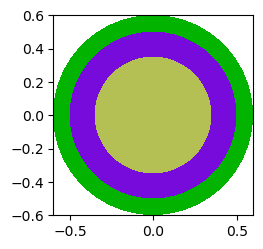

In [7]:
pin_universe.plot(**{'width':(2*r_clad_2,2*r_clad_2)})

In [8]:
num_pins = [1, 6, 12, 18]
angles = [0, 0, 15, 0]

for i, (r, n, a) in enumerate(zip(ring_radii, num_pins, angles)):
    for j in range(n):
        theta = (a + j/n*360)*pi/180.
        x = r*cos(theta)
        y = r*sin(theta)

        pin_boundary = openmc.ZCylinder(x0=x,y0=y,r=r_clad_2)
        coolant_cells[i].region &= +pin_boundary

        pin = openmc.Cell(fill=pin_universe, region=-pin_boundary)
        pin.translation = (x, y, 0)
        pin.id = (i + 1)*100 + j
        bundle_universe.add_cell(pin)

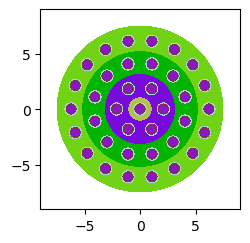

In [9]:
bundle_universe.plot(**plot_args)

In [10]:
lattice_boundary = openmc.model.RectangularParallelepiped(-lattice_pitch/2,lattice_pitch/2,-lattice_pitch/2,lattice_pitch/2,-81.6726,81.6726,boundary_type = 'reflective')

pt=openmc.Cell(fill=clad_in, region= +surf_pt_1 & -surf_pt_2)
pt.temperature = 973

bundle_universe.add_cell(pt)
moderator_cell=openmc.Cell(fill=moderator, region=-lattice_boundary & +surf_pt_2)
moderator_cell.temperature = 973

bundle_universe.add_cell(moderator_cell)

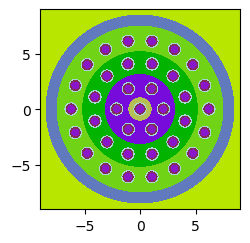

In [11]:
bdu=bundle_universe
bdu.plot(**plot_args)

In [12]:
geometry = openmc.Geometry(bdu)
geometry.export_to_xml()

materials=openmc.Materials(geometry.get_all_materials().values())
materials.export_to_xml()

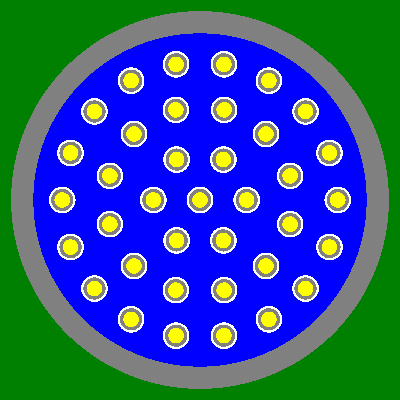

In [13]:
plot = openmc.Plot.from_geometry(geometry)
#plot.basis='xz'
#plot.origin=(0,0,-81.6725)
plot.color_by = 'material'
plot.colors = {
    fuel: 'yellow',
    clad_in: 'grey',
    clad_out: 'white',
    coolant: 'blue',
    moderator: 'green',
}
plot.to_ipython_image()

In [14]:
settings = openmc.Settings()
settings.particles = 5000
settings.batches = 100
settings.inactive = 15
settings.temperature={'method':'interpolation','range':(250, 2500)}
box = openmc.stats.Box(lower_left = (-lattice_pitch/2,-lattice_pitch/2,-H/2),
                      upper_right = (lattice_pitch/2,lattice_pitch/2,H/2),
                      only_fissionable=True);
src = openmc.Source(space=box);
settings.source = src
settings.export_to_xml()

In [15]:
fuel_tally = openmc.Tally()
fuel_tally.filters = [openmc.DistribcellFilter(fuel_cell)]

In [16]:
openmc.run()

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                #########

In [17]:
fuel.volume = pi*r_fuel**2*H*37

In [18]:
model=openmc.model.Model(geometry,materials,settings)
#operator = openmc.deplete.CoupledOperator(model,"chain_endfb80_pwr.xml")
operator = openmc.deplete.CoupledOperator(model,"chain_endfb71_pwr.xml")

power_density = 35

#time_steps = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 
#              0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 
#              0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 
#              0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 
#              0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 
#              0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 
#              0.75, 0.75, 0.75, 0.75, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
#              1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 
#              1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 
#              1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 
#              1.5]

days = 3600.*24.;
time_steps = [0.1*days, 0.25*days, 0.5*days, 1.15*days, 30*days]


#cemc = openmc.deplete.CECMIntegrator(operator,time_steps,power_density = power_density,timestep_units='MWd/kg')
cemc = openmc.deplete.CECMIntegrator(operator,time_steps,power_density = power_density,timestep_units='s');

#repeat_depletion = False;

#if(repeat_depletion):
#    cecm.integrate()

In [19]:
cemc.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Al27 from /home/sblair/OMC_DATA/endfb71_hdf5/Al27.h5
 Reading P31 from /home/sblair/OMC_DATA/endfb71_hdf5/P31.h5
 Reading S32 from /home/sblair/OMC_DATA/endfb71_hdf5/S32.h5
 Reading S33 from /home/sblair/OMC_DATA/endfb71_hdf5/S33.h5
 Reading S34 from /home/sblair/OMC_DATA/endfb71_hdf5/S34.h5
 Reading S36 from /home/sblair/OMC_DATA/endfb71_hdf5/S36.h5
 Reading Cl35 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl35.h5
 Reading Cl37 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl37.h5
 Reading Ar36 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar36.h5
 Reading Ar38 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar38.h5
 Reading Ar40 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar40.h5
 Reading K39 from /home/sblair/OMC_DATA/endfb71_hdf5/K39.h5
 Reading K40 from /home/sblair/OMC_DATA/endfb71_hdf5/K40.h5
 Reading K41 from /home/sblair/OMC_DATA/endfb71_hdf5/K41.h5


 Reading Ca40 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca40.h5
 Reading Ca42 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca42.h5
 Reading Ca43 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca43.h5
 Reading Ca44 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca44.h5
 Reading Ca46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca46.h5
 Reading Ca48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca48.h5
 Reading Sc45 from /home/sblair/OMC_DATA/endfb71_hdf5/Sc45.h5
 Reading Ti46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti46.h5
 Reading Ti47 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti47.h5
 Reading Ti48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti48.h5
 Reading Ti49 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti49.h5
 Reading Ti50 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti50.h5
 Reading V50 from /home/sblair/OMC_DATA/endfb71_hdf5/V50.h5
 Reading V51 from /home/sblair/OMC_DATA/endfb71_hdf5/V51.h5
 Reading Cr50 from /home/sblair/OMC_DATA/endfb71_hdf5/Cr50.h5
 Reading Cr52 from /home/sblair/OMC_DATA/endfb71_hdf5/Cr52.h5
 Reading Cr5

 Reading Se80 from /home/sblair/OMC_DATA/endfb71_hdf5/Se80.h5
 Reading Se82 from /home/sblair/OMC_DATA/endfb71_hdf5/Se82.h5
 Reading Br79 from /home/sblair/OMC_DATA/endfb71_hdf5/Br79.h5
 Reading Br81 from /home/sblair/OMC_DATA/endfb71_hdf5/Br81.h5
 Reading Kr78 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr78.h5
 Reading Kr80 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr80.h5
 Reading Kr82 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr82.h5
 Reading Kr83 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr83.h5
 Reading Kr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr84.h5
 Reading Kr85 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr85.h5
 Reading Kr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr86.h5
 Reading Rb85 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb85.h5
 Reading Rb86 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb86.h5
 Reading Rb87 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb87.h5
 Reading Sr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr84.h5
 Reading Sr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr86.h5
 Reading

 Reading Mo96 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo99.h5
 Reading Mo100 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo100.h5


 Reading Tc99 from /home/sblair/OMC_DATA/endfb71_hdf5/Tc99.h5
 Reading Ru96 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru96.h5
 Reading Ru98 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru98.h5
 Reading Ru99 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru99.h5
 Reading Ru100 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh105.h5
 Reading Pd102 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd102.h5
 Reading Pd104 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd104.h5
 Reading Pd105 from /home/sblair/OMC_DATA/endfb7

          1200K
          2500K


 Reading Cd108 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd108.h5
 Reading Cd110 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd110.h5
 Reading Cd111 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd111.h5
 Reading Cd112 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd112.h5
 Reading Cd113 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd113.h5
 Reading Cd114 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd116.h5
 Reading In113 from /home/sblair/OMC_DATA/endfb71_hdf5/In113.h5
 Reading In115 from /home/sblair/OMC_DATA/endfb71_hdf5/In115.h5
 Reading Sn112 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn112.h5
 Reading Sn113 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn113.h5
 Reading Sn114 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn114.h5
 Reading Sn115 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn115.h5
 Reading Sn116 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn116.h5
 Reading Sn117 from /home/sblair/O

          1200K
          2500K


 Reading Sn126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn126.h5
 Reading Sb121 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb121.h5
 Reading Sb123 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb123.h5
 Reading Sb124 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb124.h5
 Reading Sb125 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb125.h5
 Reading Sb126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb126.h5
 Reading Te120 from /home/sblair/OMC_DATA/endfb71_hdf5/Te120.h5
 Reading Te122 from /home/sblair/OMC_DATA/endfb71_hdf5/Te122.h5
 Reading Te123 from /home/sblair/OMC_DATA/endfb71_hdf5/Te123.h5
 Reading Te124 from /home/sblair/OMC_DATA/endfb71_hdf5/Te124.h5
 Reading Te125 from /home/sblair/OMC_DATA/endfb71_hdf5/Te125.h5
 Reading Te126 from /home/sblair/OMC_DATA/endfb71_hdf5/Te126.h5


          1200K
          2500K


 Reading Te127_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te127_m1.h5
 Reading Te128 from /home/sblair/OMC_DATA/endfb71_hdf5/Te128.h5
 Reading Te129_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te129_m1.h5
 Reading Te130 from /home/sblair/OMC_DATA/endfb71_hdf5/Te130.h5
 Reading Te132 from /home/sblair/OMC_DATA/endfb71_hdf5/Te132.h5
 Reading I127 from /home/sblair/OMC_DATA/endfb71_hdf5/I127.h5
 Reading I129 from /home/sblair/OMC_DATA/endfb71_hdf5/I129.h5
 Reading I130 from /home/sblair/OMC_DATA/endfb71_hdf5/I130.h5
 Reading I131 from /home/sblair/OMC_DATA/endfb71_hdf5/I131.h5
 Reading I135 from /home/sblair/OMC_DATA/endfb71_hdf5/I135.h5
 Reading Xe123 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe123.h5


 Reading Xe124 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe124.h5
 Reading Xe126 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe126.h5
 Reading Xe128 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe128.h5
 Reading Xe129 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe129.h5
 Reading Xe130 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe130.h5
 Reading Xe131 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe131.h5
 Reading Xe132 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe136.h5
 Reading Cs133 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs133.h5


          2500K


 Reading Cs134 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs137.h5
 Reading Ba130 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba130.h5
 Reading Ba132 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba132.h5
 Reading Ba133 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba133.h5


          1200K
          2500K


 Reading Ba134 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba134.h5
 Reading Ba135 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba135.h5
 Reading Ba136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba136.h5
 Reading Ba137 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba137.h5
 Reading Ba138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba138.h5
 Reading Ba140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba140.h5
 Reading La138 from /home/sblair/OMC_DATA/endfb71_hdf5/La138.h5
 Reading La139 from /home/sblair/OMC_DATA/endfb71_hdf5/La139.h5
 Reading La140 from /home/sblair/OMC_DATA/endfb71_hdf5/La140.h5
 Reading Ce136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce136.h5
 Reading Ce138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce138.h5
 Reading Ce139 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce139.h5
 Reading Ce140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce142.h5
 Reading Ce143 from /home/sblair/OMC_DAT

          1200K
          2500K


 Reading Gd152 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd152.h5
 Reading Gd153 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd153.h5
 Reading Gd154 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb160.h5
 Reading Dy156 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy156.h5
 Reading Dy158 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy158.h5
 Reading Dy160 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home/sblair/OMC_DAT

 Reading Bk249 from /home/sblair/OMC_DATA/endfb71_hdf5/Bk249.h5
 Reading Bk250 from /home/sblair/OMC_DATA/endfb71_hdf5/Bk250.h5
 Reading Cf246 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf246.h5
 Reading Cf248 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf248.h5
 Reading Cf249 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf249.h5
 Reading Cf250 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf250.h5


          1200K


 Reading Cf251 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf251.h5
 Reading Cf252 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf252.h5
 Reading Cf253 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf253.h5
 Reading Cf254 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf254.h5
 Reading Es251 from /home/sblair/OMC_DATA/endfb71_hdf5/Es251.h5
 Reading Es252 from /home/sblair/OMC_DATA/endfb71_hdf5/Es252.h5
 Reading Es253 from /home/sblair/OMC_DATA/endfb71_hdf5/Es253.h5
 Reading Es254 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254.h5
 Reading Es254_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254_m1.h5
 Reading Es255 from /home/sblair/OMC_DATA/endfb71_hdf5/Es255.h5
 Reading Fm255 from /home/sblair/OMC_DATA/endfb71_hdf5/Fm255.h5
 Maximum neutron transport energy: 8100000 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.54549
        2/1    1.50093
        3/1    1.50560
        4/1    1.50739
        5/1    1.56399
        6/1    1.53584
        7/1    1.52569
        8/1    1.49473
        9/1    1.51400
       10/1    1.51440
       11/1    1.52538
       12/1    1.53672
       13/1    1.50721
       14/1    1.52694
       15/1    1.53112
       16/1    1.48443
       17/1    1.53305    1.50874 +/- 0.02431
       18/1    1.49203    1.50317 +/- 0.01510
       19/1    1.46596    1.49387 +/- 0.01416
       20/1    1.48730    1.49255 +/- 0.01105
       21/1    1.50699    1.49496 +/- 0.00934
       22/1    1.48282    1.49323 +/- 0.00808
       23/1    1.51323    1.49573 +/- 0.00743
       24/1    1.48583    1.49463 +/- 0.00664
       25/1    1.52301    1.49746 +/- 0.00659
       26/1    1.54

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.56288
        2/1    1.54642
        3/1    1.50219
        4/1    1.53644
        5/1    1.51340
        6/1    1.55729
        7/1    1.46808
        8/1    1.51675
        9/1    1.53627
       10/1    1.49890
       11/1    1.46196
       12/1    1.49907
       13/1    1.54948
       14/1    1.50795
       15/1    1.47541
       16/1    1.52975
       17/1    1.50041    1.51508 +/- 0.01467
       18/1    1.47635    1.50217 +/- 0.01544
       19/1    1.53116    1.50942 +/- 0.01310
       20/1    1.52255    1.51204 +/- 0.01048
       21/1    1.53282    1.51551 +/- 0.00923
       22/1    1.51825    1.51590 +/- 0.00781
       23/1    1.51453    1.51573 +/- 0.00677
       24/1    1.53333    1.51768 +/- 0.00628
       25/1    1.50930    1.51685 +/- 0.00568
       26/1    1.52

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.52173
        2/1    1.51316
        3/1    1.51593
        4/1    1.52662
        5/1    1.51393
        6/1    1.50247
        7/1    1.52172
        8/1    1.49479
        9/1    1.51576
       10/1    1.51941
       11/1    1.50609
       12/1    1.52282
       13/1    1.50780
       14/1    1.51405
       15/1    1.48429
       16/1    1.51058
       17/1    1.55300    1.53179 +/- 0.02121
       18/1    1.47112    1.51156 +/- 0.02364
       19/1    1.48837    1.50576 +/- 0.01770
       20/1    1.48855    1.50232 +/- 0.01413
       21/1    1.50142    1.50217 +/- 0.01154
       22/1    1.47293    1.49799 +/- 0.01061
       23/1    1.51312    1.49988 +/- 0.00938
       24/1    1.47145    1.49672 +/- 0.00886
       25/1    1.50537    1.49759 +/- 0.00797
       26/1    1.52

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.52946
        2/1    1.53331
        3/1    1.50721
        4/1    1.50092
        5/1    1.52149
        6/1    1.54208
        7/1    1.47829
        8/1    1.49420
        9/1    1.53090
       10/1    1.54351
       11/1    1.49481
       12/1    1.50810
       13/1    1.52767
       14/1    1.54564
       15/1    1.51575
       16/1    1.52337
       17/1    1.50011    1.51174 +/- 0.01163
       18/1    1.51836    1.51395 +/- 0.00707
       19/1    1.49212    1.50849 +/- 0.00740
       20/1    1.49693    1.50618 +/- 0.00618
       21/1    1.49125    1.50369 +/- 0.00563
       22/1    1.52819    1.50719 +/- 0.00590
       23/1    1.46953    1.50248 +/- 0.00695
       24/1    1.50577    1.50285 +/- 0.00614
       25/1    1.52158    1.50472 +/- 0.00580
       26/1    1.51

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.51302
        2/1    1.49131
        3/1    1.54812
        4/1    1.50434
        5/1    1.50654
        6/1    1.50969
        7/1    1.51402
        8/1    1.48648
        9/1    1.50327
       10/1    1.50008
       11/1    1.47267
       12/1    1.51865
       13/1    1.51382
       14/1    1.52436
       15/1    1.51814
       16/1    1.50144
       17/1    1.51525    1.50834 +/- 0.00690
       18/1    1.48609    1.50092 +/- 0.00842
       19/1    1.52457    1.50684 +/- 0.00839
       20/1    1.51412    1.50829 +/- 0.00666
       21/1    1.52295    1.51074 +/- 0.00596
       22/1    1.50466    1.50987 +/- 0.00511
       23/1    1.50919    1.50978 +/- 0.00443
       24/1    1.49062    1.50765 +/- 0.00445
       25/1    1.50303    1.50719 +/- 0.00401
       26/1    1.48

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.49657
        2/1    1.51077
        3/1    1.49171
        4/1    1.50680
        5/1    1.54136
        6/1    1.50735
        7/1    1.48033
        8/1    1.48261
        9/1    1.48221
       10/1    1.48184
       11/1    1.50741
       12/1    1.52144
       13/1    1.48899
       14/1    1.52960
       15/1    1.50942
       16/1    1.53105
       17/1    1.44796    1.48951 +/- 0.04154
       18/1    1.47889    1.48597 +/- 0.02425
       19/1    1.51262    1.49263 +/- 0.01839
       20/1    1.48223    1.49055 +/- 0.01440
       21/1    1.50797    1.49345 +/- 0.01211
       22/1    1.56085    1.50308 +/- 0.01405
       23/1    1.52572    1.50591 +/- 0.01249
       24/1    1.47822    1.50283 +/- 0.01144
       25/1    1.55694    1.50824 +/- 0.01157
       26/1    1.52

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.52436
        2/1    1.55588
        3/1    1.51682
        4/1    1.47066
        5/1    1.48820
        6/1    1.49459
        7/1    1.49762
        8/1    1.48359
        9/1    1.57495
       10/1    1.55681
       11/1    1.49147
       12/1    1.48519
       13/1    1.51629
       14/1    1.51214
       15/1    1.44822
       16/1    1.51787
       17/1    1.53354    1.52571 +/- 0.00783
       18/1    1.47304    1.50815 +/- 0.01813
       19/1    1.49930    1.50594 +/- 0.01301
       20/1    1.51903    1.50856 +/- 0.01041
       21/1    1.51912    1.51032 +/- 0.00868
       22/1    1.53351    1.51363 +/- 0.00805
       23/1    1.49282    1.51103 +/- 0.00744
       24/1    1.52104    1.51214 +/- 0.00666
       25/1    1.52925    1.51385 +/- 0.00619
       26/1    1.49

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.53231
        2/1    1.53509
        3/1    1.58692
        4/1    1.52166
        5/1    1.51262
        6/1    1.51368
        7/1    1.50256
        8/1    1.48779
        9/1    1.49516
       10/1    1.49177
       11/1    1.47695
       12/1    1.47888
       13/1    1.52355
       14/1    1.51536
       15/1    1.49504
       16/1    1.47402
       17/1    1.51189    1.49296 +/- 0.01893
       18/1    1.50272    1.49621 +/- 0.01141
       19/1    1.51361    1.50056 +/- 0.00916
       20/1    1.49205    1.49886 +/- 0.00730
       21/1    1.53741    1.50528 +/- 0.00876
       22/1    1.50723    1.50556 +/- 0.00741
       23/1    1.55089    1.51123 +/- 0.00856
       24/1    1.49723    1.50967 +/- 0.00771
       25/1    1.53203    1.51191 +/- 0.00725
       26/1    1.45

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.52867
        2/1    1.52361
        3/1    1.49393
        4/1    1.47388
        5/1    1.52102
        6/1    1.52087
        7/1    1.51899
        8/1    1.50477
        9/1    1.49476
       10/1    1.48085
       11/1    1.50590
       12/1    1.51152
       13/1    1.51653
       14/1    1.48677
       15/1    1.52413
       16/1    1.54532
       17/1    1.46701    1.50617 +/- 0.03915
       18/1    1.53093    1.51442 +/- 0.02406
       19/1    1.51000    1.51332 +/- 0.01705
       20/1    1.50232    1.51112 +/- 0.01339
       21/1    1.51140    1.51116 +/- 0.01093
       22/1    1.44778    1.50211 +/- 0.01294
       23/1    1.52223    1.50462 +/- 0.01148
       24/1    1.55656    1.51039 +/- 0.01166
       25/1    1.50620    1.50998 +/- 0.01043
       26/1    1.49

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.46297
        2/1    1.48706
        3/1    1.51934
        4/1    1.52816
        5/1    1.52193
        6/1    1.49870
        7/1    1.50340
        8/1    1.51348
        9/1    1.51905
       10/1    1.49524
       11/1    1.51095
       12/1    1.52556
       13/1    1.46580
       14/1    1.46734
       15/1    1.49278
       16/1    1.47557
       17/1    1.51217    1.49387 +/- 0.01830
       18/1    1.47178    1.48651 +/- 0.01288
       19/1    1.49818    1.48943 +/- 0.00956
       20/1    1.50061    1.49166 +/- 0.00774
       21/1    1.49901    1.49289 +/- 0.00643
       22/1    1.49532    1.49323 +/- 0.00545
       23/1    1.50915    1.49522 +/- 0.00512
       24/1    1.48892    1.49452 +/- 0.00457
       25/1    1.47930    1.49300 +/- 0.00436
       26/1    1.49

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.51148
        2/1    1.48472
        3/1    1.48948
        4/1    1.46389
        5/1    1.55963
        6/1    1.51626
        7/1    1.46912
        8/1    1.48699
        9/1    1.50275
       10/1    1.44297
       11/1    1.50312
       12/1    1.49361
       13/1    1.48623
       14/1    1.53564
       15/1    1.50861
       16/1    1.49686
       17/1    1.50311    1.49999 +/- 0.00313
       18/1    1.51972    1.50656 +/- 0.00682
       19/1    1.50859    1.50707 +/- 0.00485
       20/1    1.53328    1.51231 +/- 0.00645
       21/1    1.53463    1.51603 +/- 0.00645
       22/1    1.50616    1.51462 +/- 0.00563
       23/1    1.47304    1.50943 +/- 0.00713
       24/1    1.54383    1.51325 +/- 0.00736
       25/1    1.45254    1.50718 +/- 0.00895
       26/1    1.50

In [20]:
results = openmc.deplete.Results("./depletion_results.h5")

In [21]:
time, k =results.get_keff()

In [22]:
#time /=(24*3600*1392)/48.72
#time

time /= days

In [23]:
k

array([[1.50981923e+00, 1.32520409e-03],
       [1.51046165e+00, 1.07919177e-03],
       [1.50511890e+00, 1.21196031e-03],
       [1.50564910e+00, 1.19874700e-03],
       [1.50242766e+00, 1.26638941e-03],
       [1.49524491e+00, 1.32134999e-03]])

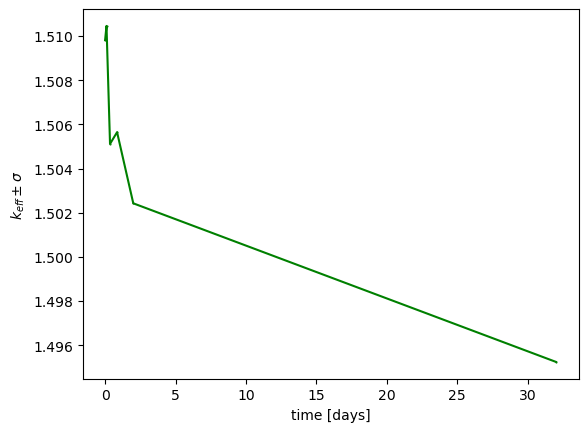

In [24]:
pyplot.errorbar(time, k[:, 0],color='green',marker='.',markersize=1)
#pyplot.xlabel("MWd/kg")
pyplot.xlabel("time [days]");
pyplot.ylabel("$k_{eff}\pm \sigma$");